# CASE 1

##Preparation

For the preparations lets import the necessary libraries and load the files needed for our exploration

In [171]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import random
import math

import warnings

warnings.filterwarnings("ignore")

!pip install squarify
import squarify

In [2]:
data = pd.read_csv("/content/TFP.csv")
data.head() # Using (head) to get the first 5 values of our dataset to check it

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [4]:
data.info # Using (info) to see a little more of our dataset, here we can get its size too, for example, this one have 186 rows and 3 columns

<bound method DataFrame.info of     isocode  year    rtfpna
0       USA  1950  0.617148
1       USA  1951  0.629588
2       USA  1952  0.638451
3       USA  1953  0.651858
4       USA  1954  0.646179
..      ...   ...       ...
181     MEX  2007  1.013673
182     MEX  2008  0.991548
183     MEX  2009  0.915879
184     MEX  2010  0.941604
185     MEX  2011  0.955766

[186 rows x 3 columns]>

In [5]:
data.describe() # With (descibre) we can get some informations regarding the max and min values, the mean of each column, each quartile, so we can have a better understanding of it

,year,rtfpna
count,186.000000,186.000000
mean,1980.500000,0.975614
std,17.943831,0.177538
min,1950.000000,0.617148
25%,1965.000000,0.855143
50%,1980.500000,0.995047
75%,1996.000000,1.046348
max,2011.000000,1.383718


In [6]:
data.nunique() # We can check the uniqueness of our columns using (nunique), we can see that we have only 3 countries(isocode), have 62 years represented (from 1950 to 2011) and have 184 values for RTFPNA


isocode      3
year        62
rtfpna     184
dtype: int64

In [7]:
data.isnull().sum() #Finally, we can check if we have any null value in the dataset

isocode    0
year       0
rtfpna     0
dtype: int64

## Data Visualization

Now, we'll plot some views of this dataset, so we can get a look on it and we can discover patterns, spot anomalies, frame our hypothesis and check our assumptions

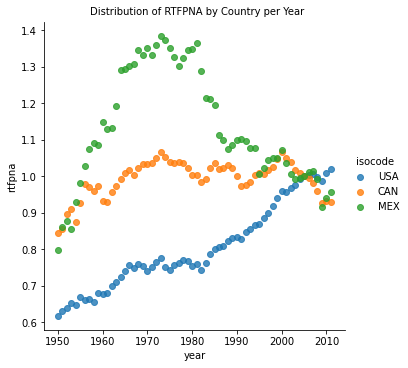

In [25]:
#Plot using the 3 Countries (isocode) by Year, using Seaborn
lm = sns.lmplot(x='year', y='rtfpna', data=data,fit_reg=False, hue='isocode')
fig = lm.fig 
fig.suptitle(x=0.5, y=1, t='Distribution of RTFPNA by Country per Year',va='center',fontsize=10)
plt.show()

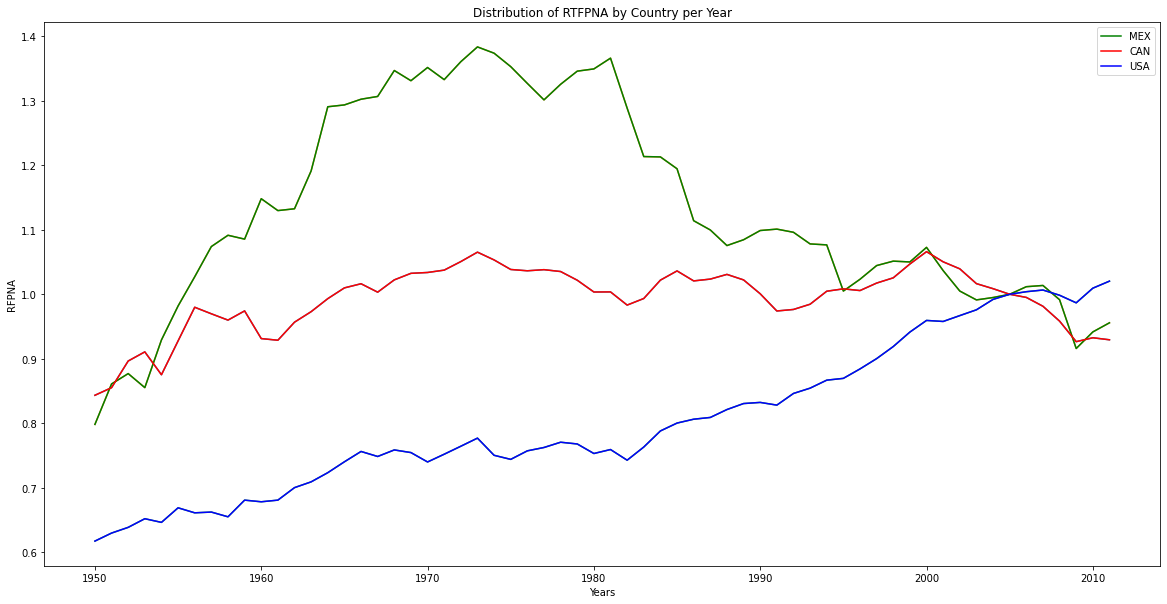

In [30]:
# Pivoting the table so that each region is a column and each row is a year.
data1 = data.pivot_table(index='year',columns='isocode',values='rtfpna')

# Ploting again using another format, with lines and in a bigger size
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Distribution of RTFPNA by Country per Year')
plt.xlabel('Years')
plt.ylabel('RFPNA')
plt.plot(data1)
ax.plot(data1.MEX, label='MEX', color='green')
ax.plot(data1.CAN, label='CAN', color='red')
ax.plot(data1.USA, label='USA', color='blue')
leg = ax.legend()
plt.show()

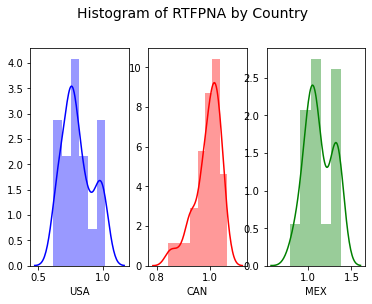

In [45]:
# Ploting the RTPFNA by Country, which allow us to get the distribution of the in a image.
fig, ax =plt.subplots(1,3)
fig.suptitle(x=0.5, y=1, t='Histogram of RTFPNA by Country',va='center',fontsize=14)
sns.distplot(data1.USA, color='blue', ax=ax[0])
sns.distplot(data1.CAN, color='red', ax=ax[1])
sns.distplot(data1.MEX, color='green', ax=ax[2])
fig.show()

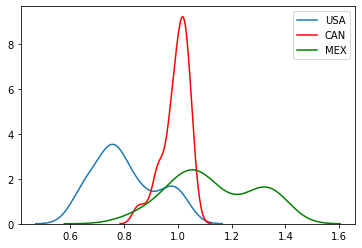

In [46]:
# Ploting all of them in one figure.
sns.kdeplot(data1.USA, label="USA")
sns.kdeplot(data1.CAN, label="CAN", color='red')
sns.kdeplot(data1.MEX, label="MEX", color='green')
plt.legend();

## Forecasting

Here,  we'll show some tryouts of forecasting, trying to get the best result so we could use it in the future

In [48]:
#Create a new dataframe with only the 'USA' column
data2 = data1.filter(['USA'])

#Converting the dataframe to a numpy array
data2 = data2.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(data2) *.8)

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(data2)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train=[]
for i in range(1,len(train_data)):
    x_train.append(train_data[i-1:i,0])
    y_train.append(train_data[i,0])

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(49, 1, 1)

In [70]:
# Now we set how we want our model, set our hidden layers, activation functions and how we want our return, in this case we want 1 value. Setted this one by trial and erro to get the best result.
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='linear'))
model.add(Dense(1))
#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [71]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=100)

Epoch 1/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0529
Epoch 2/100
49/49 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 3/100
49/49 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 5/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 8/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 9/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 10/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 11/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 12/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 13/100
49/49 [================

In [72]:
#Test data set
test_data = scaled_data[training_data_len - 1: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  data2[training_data_len : , : ]
for i in range(1,len(test_data)):
    x_test.append(test_data[i-1:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) #Undo scaling

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.014806423624032441

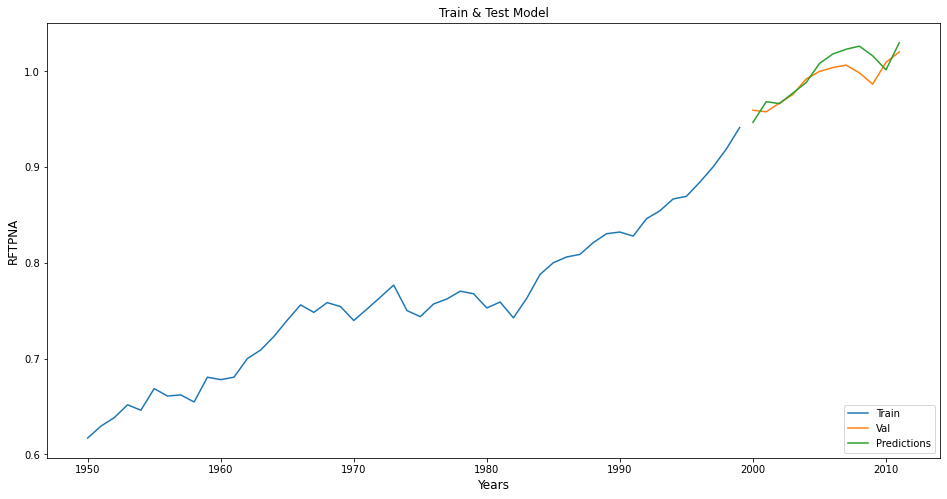

In [73]:
#Plot/Create the data for the graph
train = data1[ :training_data_len]
valid = data1[training_data_len: ]
valid['Predictions'] = predictions


#Visualize the data of how our model behave with the already known data
plt.figure(figsize=(16,8))
plt.title('Train & Test Model')
plt.xlabel('Years', fontsize=12)
plt.ylabel('RFTPNA', fontsize=12)
plt.plot(train['USA'])
plt.plot(valid[['USA', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
  

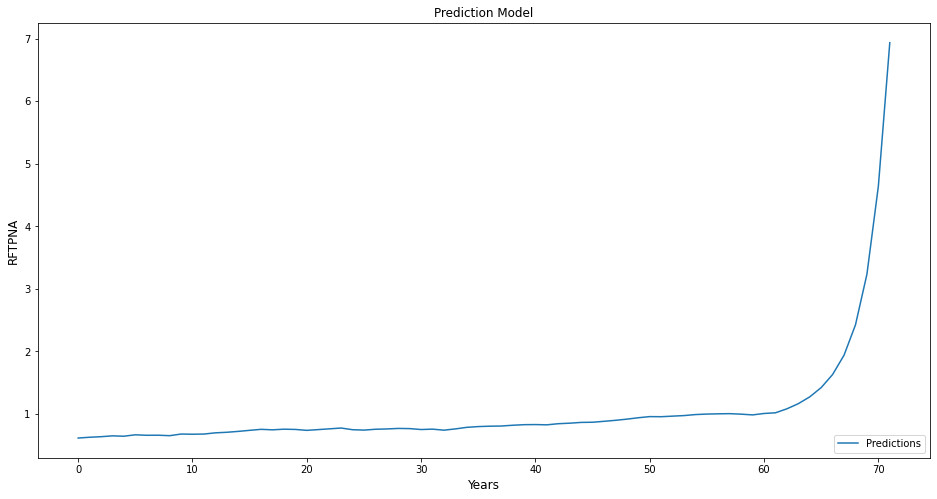

In [74]:
#Creating an copy of our used dataset, to try with LSTM to predict the 10 years
data3 = data2.copy()

#Always getting the last line of our dataset to try to predict the next year, which we use a loop to get 10 years.
for i in range(10):
  x = model.predict(np.array([[[data3[-1][0]]]]))
  data3 = np.append(data3, x, 0)

#Visualize the data of our model
plt.figure(figsize=(16,8))
plt.title('Prediction Model')
plt.xlabel('Years', fontsize=12)
plt.ylabel('RFTPNA', fontsize=12)
plt.plot(data3)
plt.legend(['Predictions'], loc='lower right')
plt.show()

Okay, now, let's try using some Decision Tree

In [136]:
usa = data1[['USA']]
usa.head()

isocode,USA
year,
1950,0.617148
1951,0.629588
1952,0.638451
1953,0.651858
1954,0.646179


In [137]:
#Variavel de predição futura - 10 anos
#future_year=10

#Criar coluna nova com o target
usa['Predict'] = usa[['USA']]

#Criar uma feature no dataset e converter para array numpy e remover os "X" anos
x = np.array(usa.drop(['Predict'],1))

#Criar o dataset que queremos (y) e conveter para numpy e pegar todos os dados exceto os anos X
y= np.array(usa['Predict'])


In [138]:
#Criar os modelos
#Decision Tree de regressão
decision_tree = DecisionTreeRegressor().fit(x, y)

In [139]:
x_forecast = np.array([[x] for x in data1['USA']])

for i in range(10):
  x = decision_tree.predict(np.array([[x_forecast[-1][0]]]))
  #print(x_forecast[-1][0])
  x_forecast = np.append(x_forecast,[x],0)

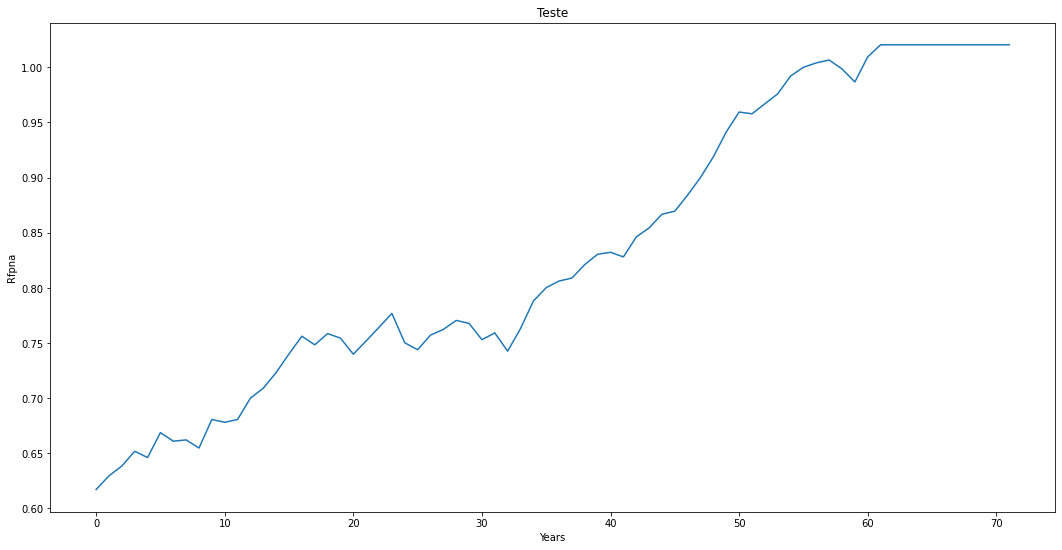

In [147]:
plt.figure(figsize=(18,9))
plt.title('Teste')
plt.xlabel('Years')
plt.ylabel('Rfpna')
plt.plot(x_forecast)
plt.show()

Decision tree tende a repetir os valores, o modelo está defasado e não é recomendado.

Now, let's try using ARIMA to forecast

In [140]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [141]:
#Creat a Pivot Table to use
series1 = data.pivot_table(index='year',columns='isocode',values='rtfpna')

# Using only USA column to start our forecast
usa = series1[['USA']]
X = usa.values
years_time = 1
differenced = difference(X, years_time)

# Fitting the model
model = ARIMA(differenced, order=(10,0,1))
model_fit = model.fit(disp=0)

In [112]:
# Multi-step out-of-sample forecast, trying for 10 steps, which represent our years
forecast = model_fit.forecast(steps=10)[0]

In [115]:
# Invert the differenced forecast for our use
history = [x for x in X]
year = 2012
x_future=[]

for yhat in forecast:
	inverted = inverse_difference(history, yhat, years_time)
	print('Day %d: %f' % (year, inverted))
	history.append(inverted)
	year += 1      

Day 2012: 1.025851
Day 2013: 1.026810
Day 2014: 1.031730
Day 2015: 1.038164
Day 2016: 1.044592
Day 2017: 1.056417
Day 2018: 1.067111
Day 2019: 1.071089
Day 2020: 1.073811
Day 2021: 1.081338


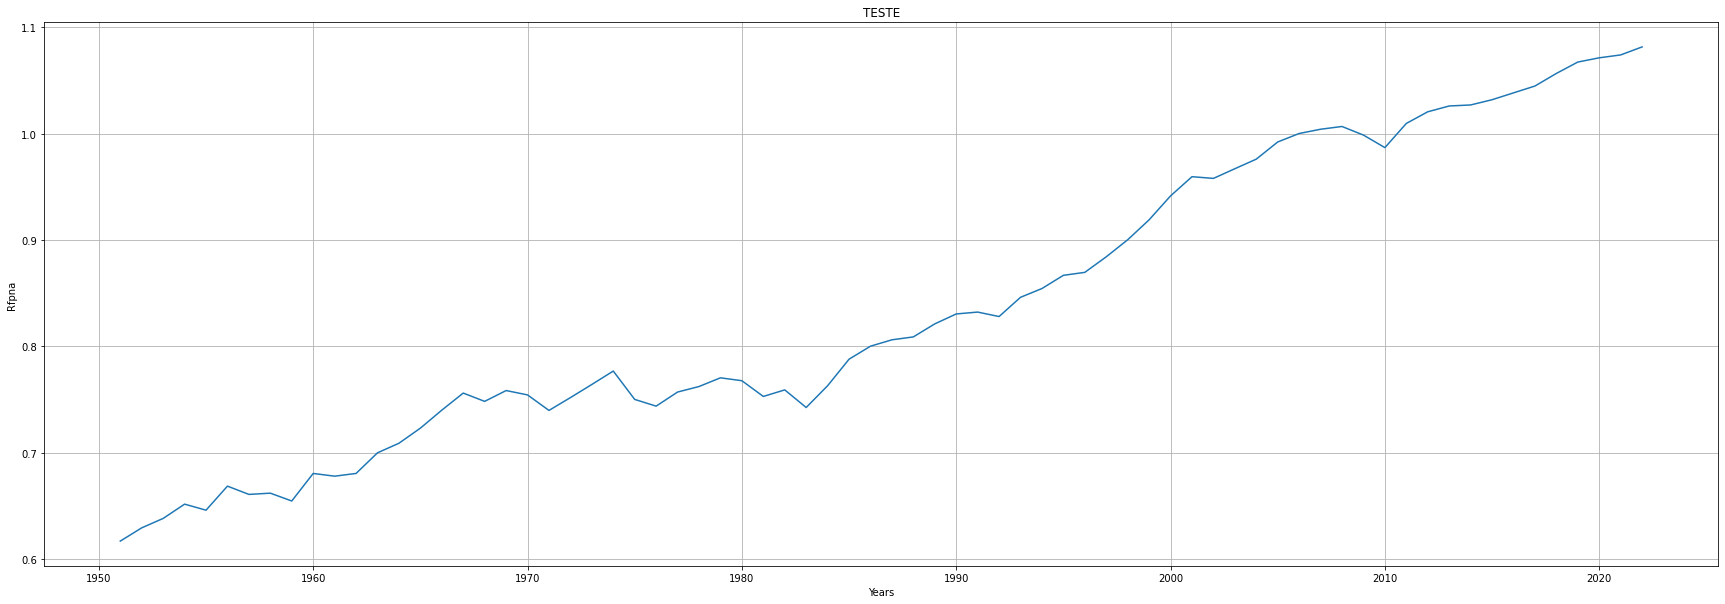

In [144]:
#Importing to a new dataframe to plot it all
dates = pd.date_range(start='1950', periods=72, freq='Y')
df = pd.DataFrame(history,index=dates, columns=['USA'])

fig, ax1 = plt.subplots(figsize =(30,10))
ax1.grid() # turn on grid #2
ax1.set_title('TESTE')
ax1.set_xlabel('Years')
ax1.set_ylabel('Rfpna')
ax1.plot(df)

By analyzing all 3 forecasts, the recommended one should be the ARIMA Mode.


*Can you think about another feature that could be helpful in explaining TFP series?*

Yes, by analyzing the displayed variables in the PWT8, we should use this variables help analyze and understand the TFP:

* CTFP = Because with it we can see the actual PPP value, the Purchasing Power Parity, which affects directly the RTFPNA growth.

* csh_r = Shows the discrepancy of GDP values and the residual trade, showing the country growth.


# Case 2

In [150]:
comex = pd.read_csv("/content/data_comexstat.csv", encoding = 'latin-1', sep = ',', parse_dates=['date'], index_col=['date'])

In [151]:
comex.head()

,product,state,country,type,route,tons,usd
date,,,,,,,
1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0


In [152]:
comex.shape

(117965, 7)

In [153]:
comex.describe

<bound method NDFrame.describe of            product state           country  ...   route       tons         usd
date                                        ...                               
1997-01-01    corn    ES     United States  ...     Sea     44.045    113029.0
1997-01-01    corn    GO         Argentina  ...  Ground     54.000     36720.0
1997-01-01    corn    GO           Bolivia  ...  Ground      0.200       180.0
1997-01-01    corn    GO     United States  ...     Sea      3.488      5688.0
1997-01-01    corn    MG         Argentina  ...  Ground     27.000     18630.0
...            ...   ...               ...  ...     ...        ...         ...
2019-12-01   wheat    SP         Argentina  ...     Sea  87124.765  17897516.0
2019-12-01   wheat    SP           Ireland  ...     Sea      0.500       477.0
2019-12-01   wheat    SP           Lebanon  ...     Sea      5.769      6726.0
2019-12-01   wheat    SP           Liberia  ...   Other      0.025        50.0
2019-12-01   wheat

In [154]:
comex.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117965 entries, 1997-01-01 to 2019-12-01
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   product  117965 non-null  object 
 1   state    117965 non-null  object 
 2   country  117965 non-null  object 
 3   type     117965 non-null  object 
 4   route    117965 non-null  object 
 5   tons     117965 non-null  float64
 6   usd      117965 non-null  float64
dtypes: float64(2), object(5)
memory usage: 7.2+ MB


In [155]:
comex.nunique()

product        6
state         27
country      212
type           2
route          5
tons       63637
usd        99273
dtype: int64

In [156]:
comex.isnull().sum()

product    0
state      0
country    0
type       0
route      0
tons       0
usd        0
dtype: int64

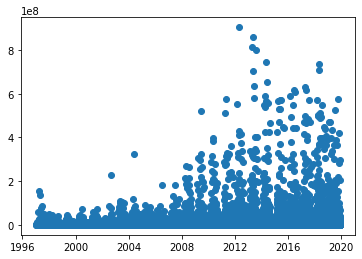

In [157]:
dates = mpl.dates.date2num(comex.loc[comex['product'] == 'soybeans', 'usd'].index.values)
plt.plot_date(dates, comex.loc[comex['product'] == 'soybeans', 'usd'])

## Question 1

###Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’.


In [165]:
soybean = comex.loc[(comex['type']=='Export') & (comex['product'].isin(['soybeans','soybean_oil','soybean_meal']))]
soybean

,product,state,country,type,route,tons,usd
date,,,,,,,
1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,419.070,119318.0
1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,5000.000,1414250.0
1997-01-01,soybean_meal,MS,Germany,Export,Sea,140.672,38378.0
1997-01-01,soybean_meal,MS,Hungary,Export,Sea,15000.000,4042100.0
1997-01-01,soybean_meal,MS,Netherlands,Export,Sea,14000.000,3850162.0
...,...,...,...,...,...,...,...
2019-12-01,soybeans,SP,Liberia,Export,Other,0.004,11.0
2019-12-01,soybeans,SP,Liberia,Export,Other,0.006,30.0
2019-12-01,soybeans,SP,Thailand,Export,Sea,146.499,52813.0


In [166]:
group_soy = soybean.groupby(soybean.index).sum()

Text(0, 0.5, 'Export in Tons per Month')

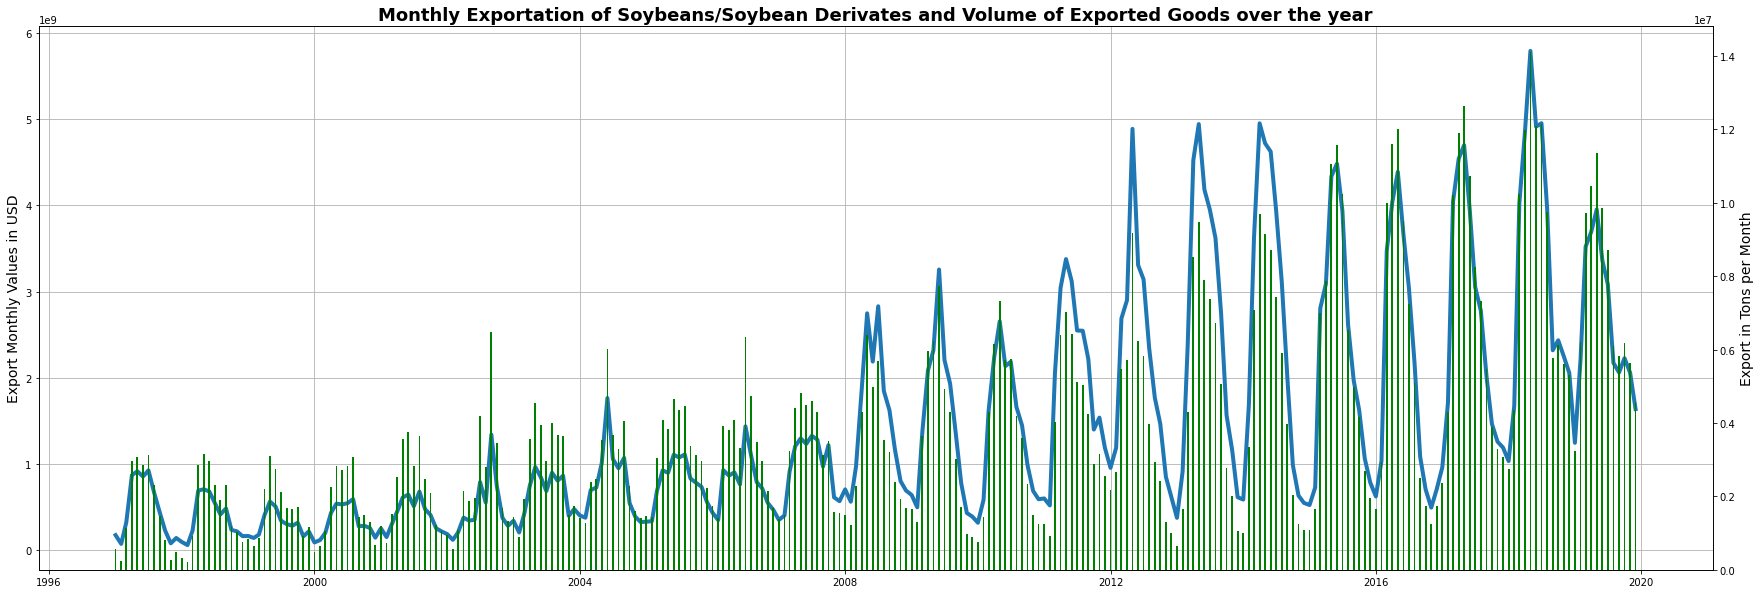

In [200]:
fig, ax1 = plt.subplots(figsize =(30,10))
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(group_soy['usd'], lw = 4) #plot the Revenue on axis #1
#ax1.xaxis_date()

ax1.grid() # turn on grid #2

ax2.bar(group_soy.index, group_soy['tons'], width=10, color = 'green')
#ax2.xaxis_date()

ax1.set_title('Monthly Exportation of Soybeans/Soybean Derivates and Volume of Exported Goods over the year', fontsize = 18, fontweight="bold")
ax1.set_ylabel('Export Monthly Values in USD', fontsize = 14)
ax2.set_ylabel('Export in Tons per Month', fontsize = 14)

## Question 2

###What are the 3 most important products exported by Brazil in the last 5 years?

In [169]:
important = comex.loc[(comex['type']=='Export') & (comex.index >= '2015-01-01')]
important

,product,state,country,type,route,tons,usd
date,,,,,,,
2015-01-01,corn,BA,Morocco,Export,Sea,7486.339,1370000.0
2015-01-01,corn,DF,Taiwan,Export,Sea,6.085,1168.0
2015-01-01,corn,ES,South Korea,Export,Sea,50.000,8135.0
2015-01-01,corn,GO,China,Export,Sea,41331.166,8143579.0
2015-01-01,corn,GO,Costa Rica,Export,Sea,40.000,13140.0
...,...,...,...,...,...,...,...
2019-12-01,wheat,PR,United States,Export,Sea,0.400,400.0
2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.000,6963002.0
2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0


In [177]:
products = important.groupby(important['product']).sum().sort_values(by='usd',ascending=False)[0:3]
products

,tons,usd
product,,
soybeans,3.263315e+08,1.233255e+11
sugar,1.200336e+08,4.093849e+10
soybean_meal,7.664749e+07,2.840772e+10
corn,1.445993e+08,2.444772e+10
soybean_oil,6.711428e+06,4.795947e+09
wheat,3.885836e+06,7.269454e+08


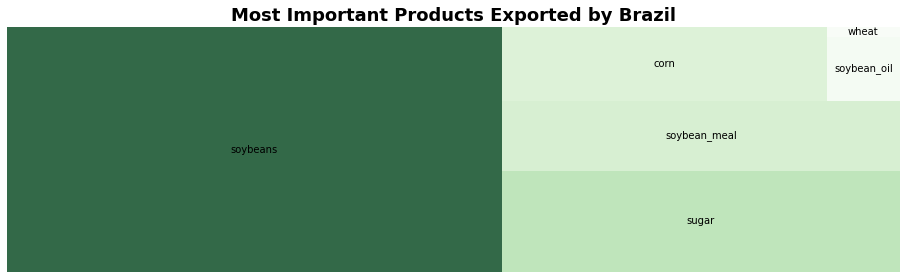

In [201]:
dataProd = products[products['usd']>0]

norm = mpl.colors.Normalize(vmin=min(dataProd.usd), vmax=max(dataProd.usd))
colors = [mpl.cm.Greens(norm(value)) for value in dataProd.usd]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label = products.index, sizes=dataProd['usd'], color = colors, alpha=.8)
plt.title("Most Important Products Exported by Brazil",fontsize=18,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()


The 3 most important are:


1.   Soybeans
2.   Sugar
3.   Soybean Meal



## Question 3

### What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importance of routes depending on the product?

In [202]:
data['route'].value_counts()

Sea       14297
Ground     2880
Other       616
Air         370
River       234
Name: route, dtype: int64

In [203]:
exporta = comex.loc[(comex['type']=='Export') & (comex.index >= '2017-01-01')]
exporta

,product,state,country,type,route,tons,usd
date,,,,,,,
2017-01-01,corn,GO,Dominican Republic,Export,Sea,795.679,147710.0
2017-01-01,corn,GO,Ecuador,Export,Air,0.122,1504.0
2017-01-01,corn,GO,Egypt,Export,Sea,199.950,533884.0
2017-01-01,corn,GO,Iran,Export,Sea,17.680,2791.0
2017-01-01,corn,GO,Iran,Export,Sea,600.000,85626.0
...,...,...,...,...,...,...,...
2019-12-01,wheat,PR,United States,Export,Sea,0.400,400.0
2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.000,6963002.0
2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0


In [204]:
corn = exporta.loc[exporta['product']=='corn'].groupby(['product','route']).sum().sort_values(by='usd',ascending=False)
corn.reset_index(inplace=True)
corn

,product,route,tons,usd
0,corn,Sea,9.002341e+07,1.498535e+10
1,corn,River,3.500016e+06,5.654711e+08
2,corn,Ground,4.824573e+04,1.130397e+08
3,corn,Other,2.624365e+05,4.359135e+07
4,corn,Air,4.162630e+02,1.880937e+06


In [205]:
routes = exporta.groupby(['route','product']).sum().sort_index()
routes.reset_index(inplace=True)
routes

,route,product,tons,usd
0,Air,corn,4.162630e+02,1.880937e+06
1,Air,soybean_meal,1.076300e+01,1.128200e+04
2,Air,soybean_oil,2.408000e+00,3.825000e+03
3,Air,soybeans,1.968800e+01,6.019400e+04
4,Air,sugar,2.525800e+01,2.709100e+04
5,Air,wheat,4.120000e-01,1.087000e+03
6,Ground,corn,4.824573e+04,1.130397e+08
7,Ground,soybean_meal,5.828548e+03,3.546417e+06
8,Ground,soybean_oil,8.791069e+04,8.626319e+07
9,Ground,soybeans,9.091980e+04,3.794101e+07


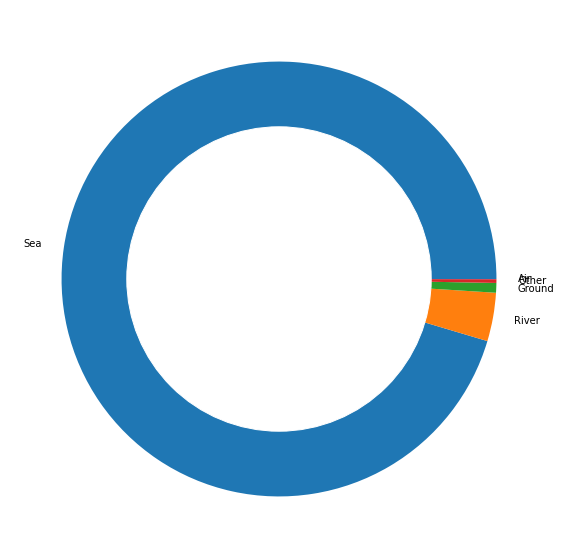

In [213]:
# Create a pieplot
fig, ax1 = plt.subplots(figsize =(30,10))
plt.pie(corn['usd'], labels= corn['route'])

my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()

In [216]:
pivot_routes = routes.pivot(index='product', columns='route', values='usd')
pivot_routes.fillna(0,inplace=True)
pivot_routes


route,Air,Ground,Other,River,Sea
product,,,,,
corn,1880937.0,113039682.0,43591351.0,5.654711e+08,1.498535e+10
soybean_meal,11282.0,3546417.0,30536840.0,0.000000e+00,1.735984e+10
soybean_oil,3825.0,86263192.0,13971109.0,1.835247e+06,2.642380e+09
soybeans,60194.0,37941012.0,542343604.0,2.196349e+09,8.024473e+10
sugar,27091.0,173825172.0,14966501.0,9.525119e+06,2.278201e+10
wheat,1087.0,402821.0,12686.0,0.000000e+00,2.578004e+08


In [217]:
adjust_route = pivot_routes.div(pivot_routes.sum(axis=1), axis=0)
adjust_route

route,Air,Ground,Other,River,Sea
product,,,,,
corn,1.197338e-04,0.007196,0.002775,0.035996,0.953914
soybean_meal,6.486169e-07,0.000204,0.001756,0.000000,0.998040
soybean_oil,1.393720e-06,0.031432,0.005091,0.000669,0.962807
soybeans,7.250418e-07,0.000457,0.006533,0.026455,0.966554
sugar,1.178876e-06,0.007564,0.000651,0.000414,0.991369
wheat,4.209637e-06,0.001560,0.000049,0.000000,0.998387


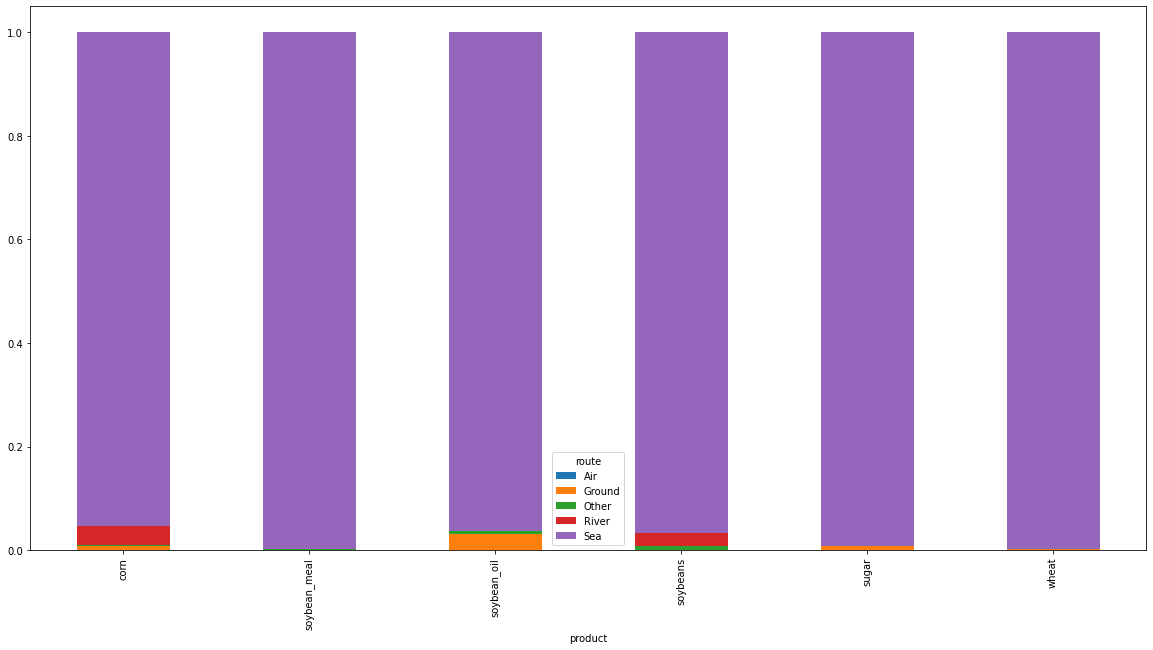

In [219]:
adjust_route.plot.bar(stacked=True, figsize=(20,10))

Clearly we can see that the main exportation route in Brazil is the Sea, but we can take it out and see if the other routes affect the products and how.

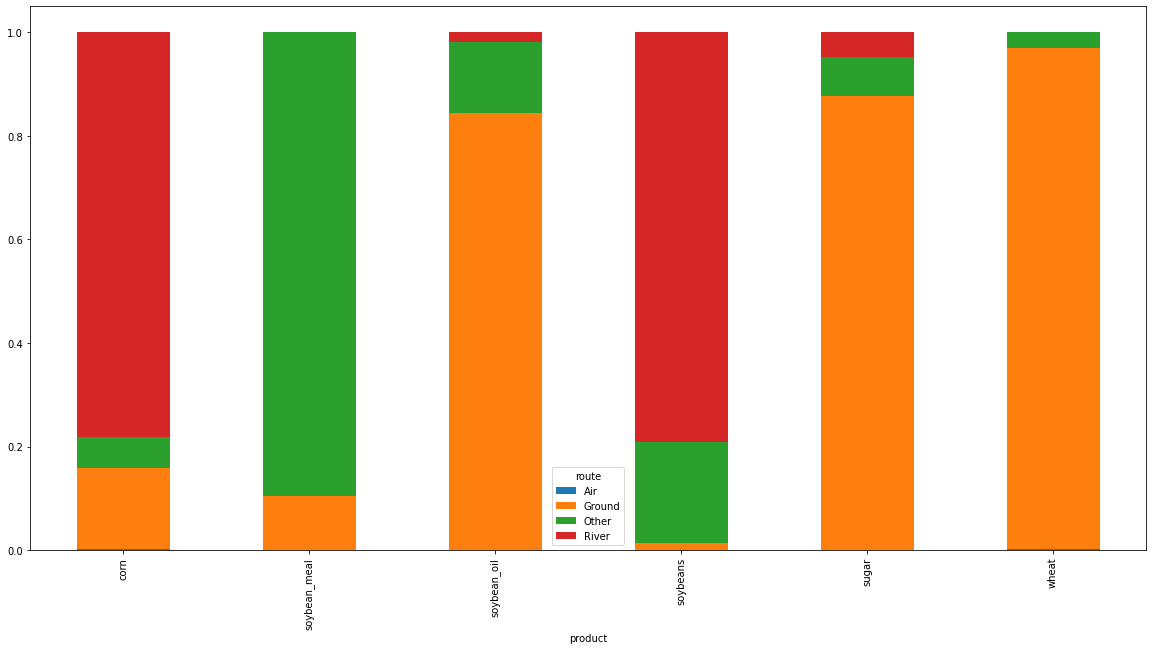

In [220]:
wo_sea = pivot_routes.drop('Sea', axis=1)
adjust_wo_sea= wo_sea.div(wo_sea.sum(axis=1), axis=0)
adjust_wo_sea
adjust_wo_sea.plot.bar(stacked=True, figsize=(20,10))

Without the Sea route, sugar, wheat and soybean oil are mostly affected by ground route and the corn and soy are mostly exported by River. With this, we can assume that, depending on the product, the route can affect the exportation, there is relevance in the routes


##Question 4

### Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

In [222]:
comex.nunique()

product        6
state         27
country      212
type           2
route          5
tons       63637
usd        99273
dtype: int64

In [224]:
#filtering
trade = comex.loc[(comex['product'].isin(['corn','sugar'])) & (comex.index >= '2017-01-01')]
trade

#groupying by
country_p = trade.groupby(['country','product']).sum().sort_index()
country_p.reset_index(inplace=True)
country_p

,country,product,tons,usd
0,Afghanistan,corn,13076.830,2.378200e+06
1,Afghanistan,sugar,27.000,9.718000e+03
2,Albania,sugar,18445.500,8.348637e+06
3,Algeria,corn,1618685.430,2.650813e+08
4,Algeria,sugar,6696854.262,2.176381e+09
...,...,...,...,...
265,Vietnam,sugar,9987.000,4.175443e+06
266,Virgin Islands (UK),corn,2242.331,3.737930e+05
267,Yemen,corn,779.280,3.412190e+05
268,Yemen,sugar,1737514.636,5.886086e+08


In [225]:
sugar = country_p.loc[(country_p['product'].isin(['sugar']))].sort_values(by ='usd', ascending=False)[0:5]
sugar

,country,product,tons,usd
4,Algeria,sugar,6696854.262,2.176381e+09
22,Bangladesh,sugar,6331640.155,2.063175e+09
113,India,sugar,5111371.882,1.696095e+09
254,United Arab Emirates,sugar,4545802.219,1.538398e+09
209,Saudi Arabia,sugar,4249461.903,1.380456e+09


In [226]:
corn2 = country_p.loc[(country_p['product'].isin(['corn']))].sort_values(by ='usd', ascending=False)[0:5]
corn2

,country,product,tons,usd
116,Iran,corn,1.642565e+07,2.822336e+09
129,Japan,corn,9.676921e+06,1.574976e+09
264,Vietnam,corn,9.446982e+06,1.551035e+09
74,Egypt,corn,8.353797e+06,1.375065e+09
223,Spain,corn,8.243946e+06,1.335780e+09


## Question 5

###For each of the products in the dataset, show the 5 most important states in terms of exports?

In [228]:
export = comex.loc[(comex['type']== 'Export')]
export

,product,state,country,type,route,tons,usd
date,,,,,,,
1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
1997-01-01,corn,MS,Paraguay,Export,Ground,40.000,38700.0
1997-01-01,corn,PR,Netherlands,Export,Sea,170000.000,20000000.0
1997-01-01,corn,PR,Paraguay,Export,Ground,258.300,386733.0
...,...,...,...,...,...,...,...
2019-12-01,wheat,PR,United States,Export,Sea,0.400,400.0
2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.000,6963002.0
2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0


In [229]:
produtos = export.groupby(['product','state']).sum()
produtos.reset_index(inplace=True)
produtos

,product,state,tons,usd
0,corn,AC,8347.480,1.857114e+06
1,corn,AL,0.010,1.800000e+01
2,corn,AM,0.815,6.620000e+02
3,corn,AP,858.682,2.498760e+05
4,corn,BA,641051.982,1.476464e+08
...,...,...,...,...
131,wheat,RJ,23.637,3.124800e+04
132,wheat,RO,1.870,3.275000e+03
133,wheat,RS,6734981.032,1.555925e+09
134,wheat,SC,81340.920,2.540009e+07


In [230]:
prod1 = produtos.loc[(produtos['product']=='corn')].sort_values(by ='usd', ascending=False)[0:5]
prod2 = produtos.loc[(produtos['product']=='soybean')].sort_values(by ='usd', ascending=False)[0:5]
prod3 = produtos.loc[(produtos['product']=='soybean_meal')].sort_values(by ='usd', ascending=False)[0:5]
prod4 = produtos.loc[(produtos['product']=='soybean_oil')].sort_values(by ='usd', ascending=False)[0:5]
prod5 = produtos.loc[(produtos['product']=='wheat')].sort_values(by ='usd', ascending=False)[0:5]
prod6 = produtos.loc[(produtos['product']=='sugar')].sort_values(by ='usd', ascending=False)[0:5]

In [231]:
produtos_definitivo = pd.concat([prod1,prod2,prod3,prod4,prod5,prod6])
produtos_definitivo

,product,state,tons,usd
12,corn,MT,1.518234e+08,2.837552e+10
17,corn,PR,5.386247e+07,9.160512e+09
8,corn,GO,2.846462e+07,5.706991e+09
11,corn,MS,1.827060e+07,3.405431e+09
24,corn,SP,7.343888e+06,1.511122e+09
36,soybean_meal,MT,7.946227e+07,2.799454e+10
40,soybean_meal,PR,8.639237e+07,2.464996e+10
45,soybean_meal,RS,4.892746e+07,1.500739e+10
32,soybean_meal,GO,2.868658e+07,9.421431e+09
29,soybean_meal,BA,1.736806e+07,5.439266e+09
